# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

In [1]:
!git clone https://github.com/cayang17/linear_models_assignment
%cd linear_models_assignment

Cloning into 'linear_models_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 6 (from 1)
Receiving objects: 100% (9/9), 18.05 KiB | 3.01 MiB/s, done.
/content/linear_models_assignment


**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

Attached in GitHub repo

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

%matplotlib inline

#2.1)
df = pd.read_csv("./data/cars_hw.csv")

print(df.info())
print(df.describe())

# remove extremely low prices
df = df[df["Price"] > 1000].copy()

df["Price"] = np.log1p(df["Price"])

df["Mileage_Run"] = np.arcsinh(df["Mileage_Run"])

# clean rows
numeric_features = ["Mileage_Run", "Make_Year", "Seating_Capacity"]
df = df.dropna(subset=numeric_features).copy()

print(df[numeric_features + ["Price"]].describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         976 non-null    int64 
 1   Make               976 non-null    object
 2   Make_Year          976 non-null    int64 
 3   Color              976 non-null    object
 4   Body_Type          976 non-null    object
 5   Mileage_Run        976 non-null    int64 
 6   No_of_Owners       976 non-null    object
 7   Seating_Capacity   976 non-null    int64 
 8   Fuel_Type          976 non-null    object
 9   Transmission       976 non-null    object
 10  Transmission_Type  976 non-null    object
 11  Price              976 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 91.6+ KB
None
       Unnamed: 0    Make_Year   Mileage_Run  Seating_Capacity         Price
count  976.000000   976.000000    976.000000        976.000000  9.760000e+02
mean   488.500000  2016.963

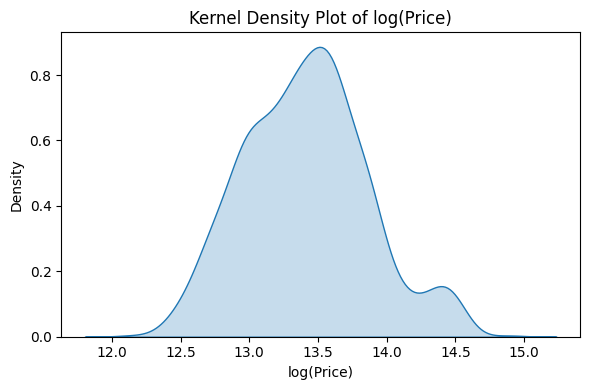

Summary of log(Price) by Make:
               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  12.919898  0.480974  12.495008  12.568395  12.752289   
Datsun           3.0  12.576050  0.036311  12.538971  12.558305  12.577640   
Ford            52.0  13.468282  0.210894  12.577640  13.361382  13.469494   
Honda           73.0  13.536319  0.336971  12.663501  13.272508  13.573440   
Hyundai        305.0  13.368512  0.398781  12.421188  13.091906  13.366095   
Jeep             4.0  14.216591  0.105084  14.070154  14.183271  14.240266   
Kia              8.0  14.292178  0.076877  14.129592  14.272242  14.303106   
MG Motors       35.0  14.439052  0.066263  14.278616  14.395745  14.429615   
Mahindra        18.0  13.898954  0.159906  13.587356  13.851809  13.905681   
Maruti Suzuki  293.0  13.218134  0.371408  12.375820  12.926351  13.174958   

                     75%        

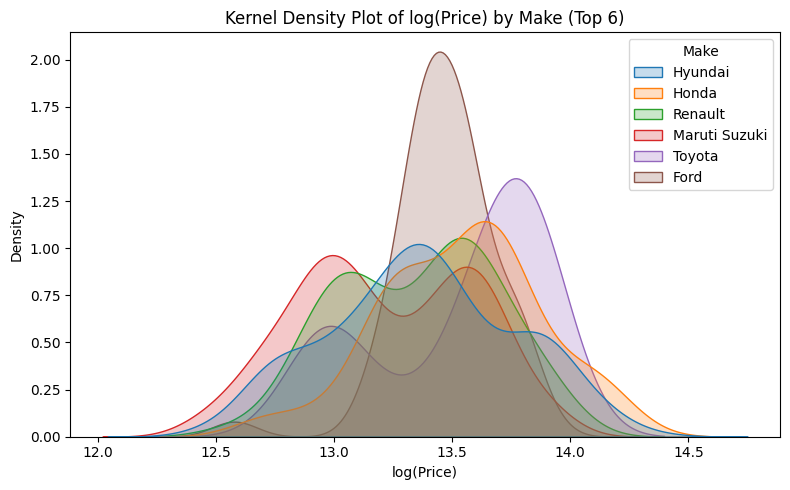

In [4]:
#2.2)
# kernel density of log Price
plt.figure(figsize=(6, 4))
sns.kdeplot(df["Price"], fill=True)
plt.title("Kernel Density Plot of log(Price)")
plt.xlabel("log(Price)")
plt.tight_layout()
plt.show()

# summary by Make
make_summary = df.groupby("Make")["Price"].describe()
print("Summary of log(Price) by Make:")
print(make_summary.head(10))

# group KDE by Make
top_makes = df["Make"].value_counts().head(6).index
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df[df["Make"].isin(top_makes)],
    x="Price",
    hue="Make",
    common_norm=False,
    fill=True,
)
plt.title("Kernel Density Plot of log(Price) by Make (Top 6)")
plt.xlabel("log(Price)")
plt.tight_layout()
plt.show()

The car prices distributions are moderately concentrated with one main peak. This suggests a large, mid priced market. However, brand plays an important role in shifting the distribution because some manufactureres consistently price higher than others (Ex: luxury leaning or premium brans occupy the upper tail end). Some higher priced brands are MG motors, Kia, Jeep, and Mahindra

The combination of a unimodal global price distribution and brand-specific shifts show that brand identity is a meaningful, but not exclusive, predictor of car price.

In [5]:
#2.3)
y = df["Price"]
X = df.drop(columns=["Price"])

categorical_features = [
    "Color",
    "Body_Type",
    "Make",
    "Fuel_Type",
    "Transmission",
    "Transmission_Type",
]

# split data in 80 and 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
#2.4)
def evaluate(model, X_train, y_train, X_test, y_test, name="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(
        f"{name:20s} | "
        f"Train R2: {train_r2:6.3f}, Test R2: {test_r2:6.3f}, "
        f"Train RMSE: {rmse_train:8.3f}, Test RMSE: {rmse_test:8.3f}"
    )
    return {
        "name": name,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": rmse_train,
        "test_rmse": rmse_test,
        "model": model,
    }

results = []

# Model 1: numeric-only linear regression
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]

linreg_num = LinearRegression().fit(X_train_num, y_train)
results.append(
    evaluate(linreg_num, X_train_num, y_train, X_test_num, y_test, "Numeric only")
)

# Model 2: categorical-only linear regression with one-hot encoding
preprocessor_cat = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop",
)

linreg_cat = Pipeline(
    steps=[
        ("preprocessor", preprocessor_cat),
        ("regressor", LinearRegression()),
    ]
)
linreg_cat.fit(X_train, y_train)
results.append(
    evaluate(linreg_cat, X_train, y_train, X_test, y_test, "Categorical only")
)

# Model 3: combined numeric + categorical
preprocessor_full = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

linreg_full = Pipeline(
    steps=[
        ("preprocessor", preprocessor_full),
        ("regressor", LinearRegression()),
    ]
)
linreg_full.fit(X_train, y_train)
results.append(
    evaluate(linreg_full, X_train, y_train, X_test, y_test, "Numeric + categorical")
)


Numeric only         | Train R2:  0.425, Test R2:  0.400, Train RMSE:    0.344, Test RMSE:    0.338
Categorical only     | Train R2:  0.673, Test R2:  0.655, Train RMSE:    0.259, Test RMSE:    0.257
Numeric + categorical | Train R2:  0.831, Test R2:  0.818, Train RMSE:    0.186, Test RMSE:    0.186


This chart shows that while categorical features provide more predictive power than numeric features alone, the best performance is achieved by combining both. Combining them allows the model to explain a much larger fraction of price variation and substantially reduves prediction error.

In [8]:
#2.5)
max_degree = 5
poly_results = []

for d in range(1, max_degree + 1):
    poly_model = make_pipeline(
        PolynomialFeatures(degree=d, include_bias=False),
        LinearRegression(),
    )
    poly_model.fit(X_train_num, y_train)
    stats = evaluate(
        poly_model,
        X_train_num,
        y_train,
        X_test_num,
        y_test,
        name=f"Polynomial degree {d}",
    )
    poly_results.append((d, stats["test_r2"], stats["test_rmse"]))

print("\nPolynomial Results (numeric features only):")
for d, r2, rmse in poly_results:
    print(f"Degree {d}: Test R2 = {r2:6.3f}, Test RMSE = {rmse:8.3f}")


Polynomial degree 1  | Train R2:  0.425, Test R2:  0.400, Train RMSE:    0.344, Test RMSE:    0.338
Polynomial degree 2  | Train R2:  0.454, Test R2:  0.418, Train RMSE:    0.335, Test RMSE:    0.333
Polynomial degree 3  | Train R2:  0.458, Test R2:  0.409, Train RMSE:    0.333, Test RMSE:    0.336
Polynomial degree 4  | Train R2:  0.459, Test R2:  0.407, Train RMSE:    0.333, Test RMSE:    0.336
Polynomial degree 5  | Train R2:  0.459, Test R2:  0.407, Train RMSE:    0.333, Test RMSE:    0.336

Polynomial Results (numeric features only):
Degree 1: Test R2 =  0.400, Test RMSE =    0.338
Degree 2: Test R2 =  0.418, Test RMSE =    0.333
Degree 3: Test R2 =  0.409, Test RMSE =    0.336
Degree 4: Test R2 =  0.407, Test RMSE =    0.336
Degree 5: Test R2 =  0.407, Test RMSE =    0.336


AS the polynomial degree increases, from 1 to 5, the change first to second degree has a small improvement when allowing nonlinearity (R2). From degree 2 to 4, it decreases, and from 4 to 5, it stays the same. R2 is never negative. The best polynomial model is degree 2, R2 = 0.418, Test RMSE = 0.333.The best polynomial model explains far less variance than the joint model and also has much higher prediction error. The joint categorical model from part 4 performs much better.

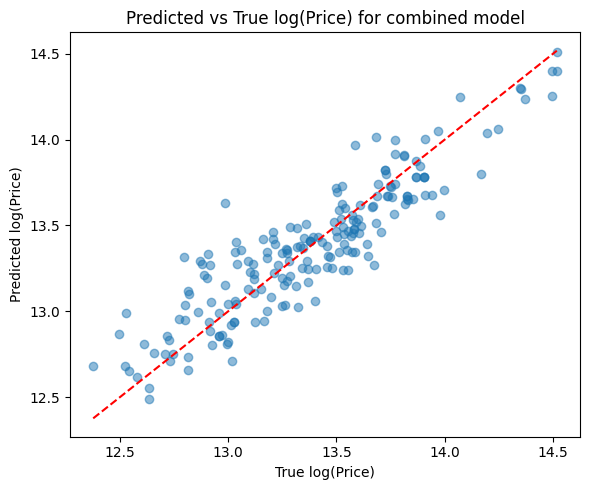

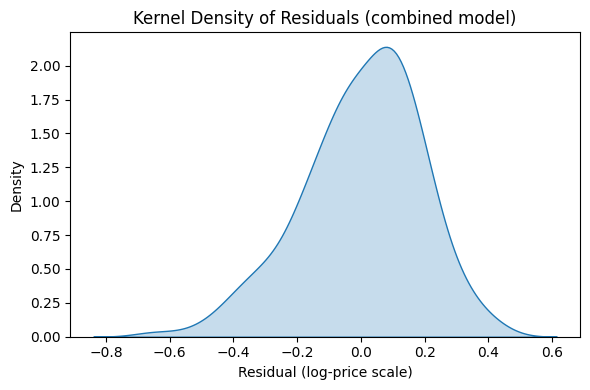

Residual mean: 0.0013922680059492664
Residual std : 0.18694680922347925


In [21]:
#2.6)
y_test_pred = linreg_full.predict(X_test)

# Scatter: Predicted vs True log-prices
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("True log(Price)")
plt.ylabel("Predicted log(Price)")
plt.title("Predicted vs True log(Price) for combined model")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals, fill=True)
plt.title("Kernel Density of Residuals (combined model)")
plt.xlabel("Residual (log-price scale)")
plt.tight_layout()
plt.show()

print("Residual mean:", residuals.mean())
print("Residual std :", residuals.std())

Yes, the points in the Predicted vs True log(Price) scatter plot lie closely along the 45 degree diagonal. The residual standard deviation of the plot is about 0.187 and the reiduals are approximately normally distributed around 0. Some strengths of the model is good predictive accuracy, centered near zero and approximately normal residuals, and effective feature usage by combining numeric and categorical vairables. Some weaknesses are noticeable variance around the diagonal, the slight wide spread of the residual in the mid to upper price rance, and omitted factors like condition, optional features, etc that could further improve accuracy of the model.

**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?